# Deep Learning Mini-Challenge 1: Image Classification

**Author**: Lukas Reber

**Task**: Train a neural network to classify images from the CIFAR-10 dataset. Focus will be on the training and evaluation of the model, not on the data preprocessing. We will use PyTorch to implement a Multi Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) to classify images the images.

**Dataset**: The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

## Import dependencies & load data

In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import wandb
from datetime import datetime

In [2]:
# login to w&b
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukasreber (lukas_fhnw). Use `wandb login --relogin` to force relogin


True

In [3]:
# check if gpu support on the m1 mac or cuda is available
if torch.backends.mps.is_available() & torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [4]:
# ensure deterministic behavior
torch.manual_seed(10)
np.random.seed(10)

We can directly load the CIFAR-10 dataset from PyTorch's `torchvision` package. Since the data consists of images or range [0,255], we normalize the data to range [0,1]. (RGB values range from 0-255, therefore by dividing by 255 we normalize the data to range [0,1].)

In [5]:
# load the data and normalize it

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'Shape: {cifar_train.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Shape: (50000, 32, 32, 3)


We now have the data in the correct shape and range. As we can see, there are 50000 training images, with three layers (RGB) and 32x32 pixels each. We can look at some random images from the training set to get a better idea of the data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

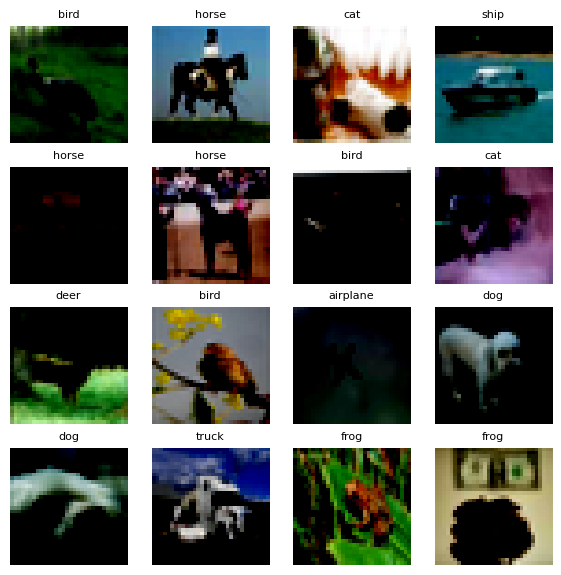

In [7]:
# plot sample images
rand_idx = np.random.randint(0, len(cifar_train), 16)
fig, axs = plt.subplots(4,4, figsize=(7,7))
for i, ax in enumerate(axs.flat):
    ax.imshow(cifar_train[rand_idx[i]][0].permute(1,2,0))
    ax.set_title(cifar_train.classes[cifar_train[rand_idx[i]][1]], size=8)
    ax.axis('off')
plt.show()

We can also see that the classes are balanced in the dataset.

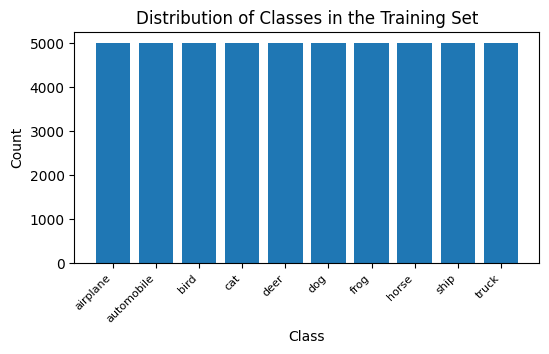

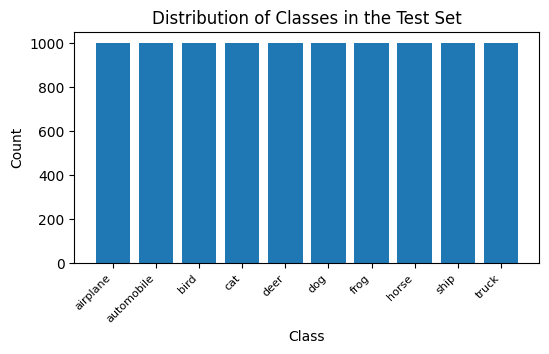

In [6]:
# display distribution of classes
values, counts = np.unique(cifar_train.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Training Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_train.classes, rotation=45, ha='right', size=8)
plt.show()

values, counts = np.unique(cifar_test.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Test Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_test.classes, rotation=45, ha='right', size=8)
plt.show()

Source:

- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- 

In [7]:
def model_eval(model, data, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for d in data:
            x_test, y_test = d[0].to(device), d[1].to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    
    return correct / total

def model_training(modelclass, optimizer, traindata, testdata, criterion, epochs, device, params):

    # wandb.init(project="del_mc1", config=params, name=f'{params["architecture"]}_lr{params["learning_rate"]}_bs{params["batch_size"]}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}')
    
    model = modelclass()
    model = model.to(device)
    optimizer = optimizer(model)

    stats = {
        'loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(traindata, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass + zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()

            # step with optimizer
            optimizer.step()

            # statistics
            stats['loss'].append(loss.item())
            wandb.log({'loss': loss.item()})
            running_loss += loss.item()
            if i % 100 == 0:    # print every 100 mini-batches
                print(f'epoch: {epoch+1}, iteration: {i} loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        # test the model after each epoch
        test_acc = model_eval(model, testdata, device)
        train_acc = model_eval(model, traindata, device)
        stats['test_acc'].append(test_acc)
        stats['train_acc'].append(train_acc)
        wandb.log({'test_acc': test_acc, 'train_acc': train_acc})
        print(f'Epoch {epoch+1}: Test Accuracy: {100 * test_acc}%, Train Accuracy: {100 * train_acc}%')

    # wandb.finish()

    # return stats



In [10]:
def plot_eval(stats):
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].plot(stats['loss'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')

    axs[1].plot(stats['train_acc'], label='train')
    axs[1].plot(stats['test_acc'], label='test')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

In [8]:
# Model 1: MLP with 1 hidden layer
class MLP_1(nn.Module):
    
    def __init__(self, input_size, output_size, fc1_size, fc2_size):
        super(MLP_1, self).__init__()
        
        self.fc1 = nn.Linear(input_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, output_size)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In order to train the model we need:
- A loss function: This is the function that we want to minimize. In this case we use the cross entropy loss.
- An optimizer: This is the algorithm that we use to update the weights of the model. In this case we use Stochastic Gradient Descent (SGD).
- Metrics: to monitor the performance of the model during training and evaluation. In this case we use accuracy.

In [20]:
# train first model
config = dict(
    epochs=2,
    classes=10,
    kernels=[],
    batch_size=100,
    learning_rate=0.01,
    dataset='cifar10',
    architecture='mlp',
    optimizer='SGD',
    loss='CrossEntropyLoss',
    activation='relu',
    hidden_layers=[128, 64],
    input_size=32*32*3,
    output_size=10,
)

mlp_1 = model_training(
    modelclass=lambda: MLP_1(config['input_size'], config['output_size'],config['hidden_layers'][0], config['hidden_layers'][1]),
    optimizer=lambda model: torch.optim.SGD(model.parameters(), lr=config['learning_rate']),
    traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config['batch_size'], shuffle=True),
    testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config['batch_size'], shuffle=True),
    criterion=nn.CrossEntropyLoss(),
    epochs=config['epochs'],
    device=device,
    params=config
)


epoch: 1, iteration: 0 loss: 0.023
epoch: 1, iteration: 100 loss: 2.277
epoch: 1, iteration: 200 loss: 2.217
epoch: 1, iteration: 300 loss: 2.145
epoch: 1, iteration: 400 loss: 2.069
Epoch 1: Test Accuracy: 30.65%, Train Accuracy: 30.165999999999997%
epoch: 2, iteration: 0 loss: 0.019
epoch: 2, iteration: 100 loss: 1.973
epoch: 2, iteration: 200 loss: 1.921
epoch: 2, iteration: 300 loss: 1.882
epoch: 2, iteration: 400 loss: 1.844
Epoch 2: Test Accuracy: 36.49%, Train Accuracy: 36.012%


loss,██▇▇▇▇▇▆▇▆▆▆▆▅▄▄▄▄▅▅▄▃▅▄▃▄▄▁▂▃▂▂▃▁▃▂▂▅▁▁
test_acc,▁█
train_acc,▁█
loss,1.9247
test_acc,0.3649
train_acc,0.36012


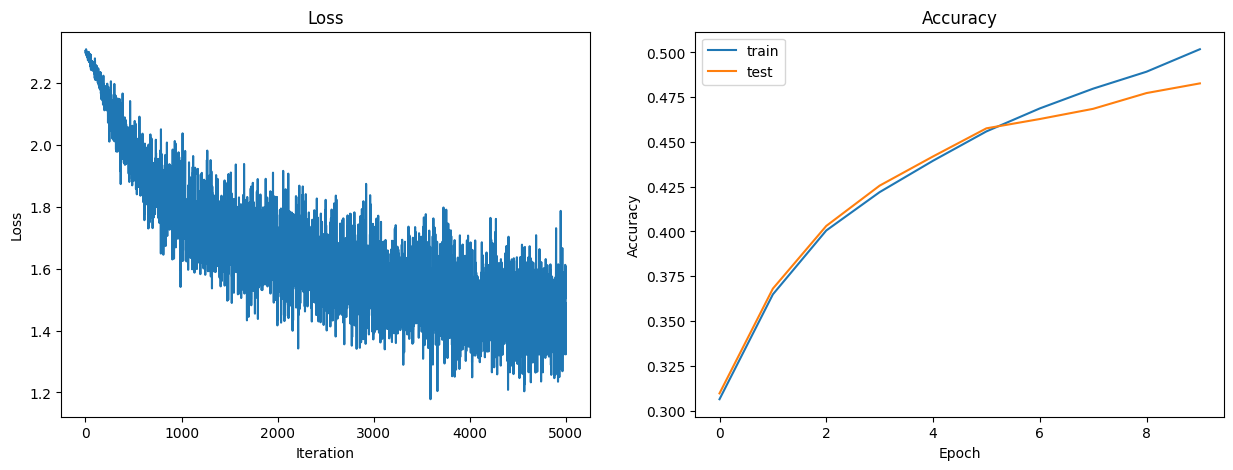

In [15]:
plot_eval(mlp_1)

In [19]:
def train_mlp_1(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'
        
        print(config)

        model_training(
            modelclass=lambda: MLP_1(config.input_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate),
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=2,
            device=device,
            params=config
        )

In [21]:
# try sweep config
sweep_config = {
    'name': 'MLP_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 2
            },
        'batch_size': {
            'value': 100,
        },
        'learning_rate': {
            'values': [0.01, 0.1]
        },
        'architecture': {
            'value': 'mlp'
        },
        'optimizer': {
            'value': 'SGD'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_mlp_1)

Create sweep with ID: ix0qjoku
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/ix0qjoku


wandb: Agent Starting Run: rpnrm533 with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 100
wandb: 	epochs: 2
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: SGD
wandb: 	output_size: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'activation': 'relu', 'architecture': 'mlp', 'batch_size': 100, 'epochs': 2, 'hidden_layers': [128, 64], 'input_size': 3072, 'learning_rate': 0.01, 'loss': 'CrossEntropyLoss', 'optimizer': 'SGD', 'output_size': 10}
epoch: 1, iteration: 0 loss: 0.023
epoch: 1, iteration: 100 loss: 2.277
epoch: 1, iteration: 200 loss: 2.210
epoch: 1, iteration: 300 loss: 2.128
epoch: 1, iteration: 400 loss: 2.046
Epoch 1: Test Accuracy: 31.45%, Train Accuracy: 30.974%
epoch: 2, iteration: 0 loss: 0.019
epoch: 2, iteration: 100 loss: 1.942
epoch: 2, iteration: 200 loss: 1.891
epoch: 2, iteration: 300 loss: 1.860
epoch: 2, iteration: 400 loss: 1.837
Epoch 2: Test Accuracy: 36.919999999999995%, Train Accuracy: 36.69%


loss,███▇▇▇▇▇▇▆▆▅▅▆▅▄▅▃▄▄▃▅▃▄▄▃▄▁▄▂▃▃▂▂▃▁▃▂▂▃
test_acc,▁█
train_acc,▁█
loss,1.7269
test_acc,0.3692
train_acc,0.3669


wandb: Agent Starting Run: zhg0hb9t with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 100
wandb: 	epochs: 2
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	learning_rate: 0.1
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: SGD
wandb: 	output_size: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'activation': 'relu', 'architecture': 'mlp', 'batch_size': 100, 'epochs': 2, 'hidden_layers': [128, 64], 'input_size': 3072, 'learning_rate': 0.1, 'loss': 'CrossEntropyLoss', 'optimizer': 'SGD', 'output_size': 10}
epoch: 1, iteration: 0 loss: 0.023
epoch: 1, iteration: 100 loss: 2.011
epoch: 1, iteration: 200 loss: 1.776
epoch: 1, iteration: 300 loss: 1.687
epoch: 1, iteration: 400 loss: 1.641
Epoch 1: Test Accuracy: 43.07%, Train Accuracy: 43.74%
epoch: 2, iteration: 0 loss: 0.017
epoch: 2, iteration: 100 loss: 1.546
epoch: 2, iteration: 200 loss: 1.520
epoch: 2, iteration: 300 loss: 1.520
epoch: 2, iteration: 400 loss: 1.484
Epoch 2: Test Accuracy: 48.35%, Train Accuracy: 50.44800000000001%


loss,█▇▆▆▅▅▅▄▄▄▃▄▄▅▃▄▄▄▄▄▄▃▄▃▂▄▄▄▃▃▃▄▃▄▁▃▄▃▃▂
test_acc,▁█
train_acc,▁█
loss,1.48363
test_acc,0.4835
train_acc,0.50448


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
